# CITATION LOCATION - clustering analysis using street/cross street location
Holding other variables constant and only examining for location, am I able to find areas of the city with specific types of clustering?

### IMPORT LIBRARIES AND DATA

In [100]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')
# plt.style.use('bmh')
plt.rcParams['patch.edgecolor'] = 'none'
import jenkspy

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [101]:
# read in data that has already been preprocessed
df = pd.read_csv('data/clustering_features.csv')

In [102]:
df.shape

(36626, 11)

In [103]:
df.head()

,beat,cited_person_age,citation_time,charge_description,street,month,day_of_week,week_of_year,hour_of_day,place_id,age_breaks
0,12.0,19.0,747,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,7,E Shea Bl - 6xxx,"(17.999, 24.0]"
1,12.0,36.0,800,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,8,E Shea Bl - 6xxx,"(30.0, 39.0]"
2,7.0,61.0,853,Speed Greater Than R&P or Posted,N Goldwater Bl,7,2,28,8,N Goldwater Bl - 4xxx,"(51.0, 97.0]"
3,7.0,59.0,843,Speed Greater Than R&P or Posted,N Goldwater Bl,7,3,28,8,N Goldwater Bl - 4xxx,"(51.0, 97.0]"
4,19.0,23.0,2215,Speed Greater Than R&P or Posted,N Pima Rd,7,5,27,22,N Pima Rd - 2xxx,"(17.999, 24.0]"


In [104]:
# drop features I don't want to use for now
df.drop(['place_id'], axis=1, inplace=True)
df.drop(['citation_time'], axis=1, inplace=True)
df.drop(['beat'], axis=1, inplace=True)
df.drop(['age_breaks'], axis=1, inplace=True)

In [105]:
# df.drop(['street'], axis=1, inplace=True)

In [106]:
# drop citations where beat is null
# otherwise this creates problems for modeling

df.drop(df[df.street.isnull()].index, inplace=True)

In [107]:
# verify no null values remain
df.isnull().sum()

cited_person_age      0
charge_description    0
street                0
month                 0
day_of_week           0
week_of_year          0
hour_of_day           0
dtype: int64

In [108]:
df.head()

,cited_person_age,charge_description,street,month,day_of_week,week_of_year,hour_of_day
0,19.0,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,7
1,36.0,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,8
2,61.0,Speed Greater Than R&P or Posted,N Goldwater Bl,7,2,28,8
3,59.0,Speed Greater Than R&P or Posted,N Goldwater Bl,7,3,28,8
4,23.0,Speed Greater Than R&P or Posted,N Pima Rd,7,5,27,22


In [109]:
# how many street locations are there?
len(df.street.unique())

1743

In [110]:
# find top 20 locations by count of citation
df.street.value_counts().head(20)

N Scottsdale Rd                     2587
E Indian School Rd                  1319
E Shea Bl                           1247
N Hayden Rd                         1201
E Camelback Rd                       947
E McDowell Rd                        888
N Pima Rd                            754
E Thomas Rd                          751
E Indian Bend Rd                     663
E Chaparral Rd                       514
E Via Linda                          466
E Cactus Rd                          385
E Redfield Rd                        311
N Scottsdale Rd / E Thomas Rd        287
E Frank Lloyd Wright Bl / L101       279
N 64th St                            270
E Frank Lloyd Wright Bl              252
E McDowell Rd / N Scottsdale Rd      250
N Hayden Rd / E Indian School Rd     248
E Camelback Rd / N Scottsdale Rd     245
Name: street, dtype: int64

In [111]:
# find top 20 locations by count of citation
df.street.value_counts().head(20).index

Index(['N Scottsdale Rd', 'E Indian School Rd', 'E Shea Bl', 'N Hayden Rd',
       'E Camelback Rd', 'E McDowell Rd', 'N Pima Rd', 'E Thomas Rd',
       'E Indian Bend Rd', 'E Chaparral Rd', 'E Via Linda', 'E Cactus Rd',
       'E Redfield Rd', 'N Scottsdale Rd / E Thomas Rd',
       'E Frank Lloyd Wright Bl / L101', 'N 64th St',
       'E Frank Lloyd Wright Bl', 'E McDowell Rd / N Scottsdale Rd',
       'N Hayden Rd / E Indian School Rd', 'E Camelback Rd / N Scottsdale Rd'],
      dtype='object')

In [112]:
# limit dataset to top 20
df = df[df.street.isin(list(df.street.value_counts().head(20).index))]

In [30]:
# how many values are captured in the limited dataset?
df.shape

(13864, 7)

In [31]:
X = pd.get_dummies(df.drop(['street'], axis=1))

In [32]:
X.head()

,cited_person_age,month,day_of_week,week_of_year,hour_of_day,charge_description_DUI-Impaired to Slightest Degree,charge_description_Drug Paraphernalia-Possess/Use,charge_description_Expired/No Arizona Registration,charge_description_Fail to Obey Traffic Control Device,charge_description_Fail to Stop For Red Signal,charge_description_Fail to Stop at Stop Sign,charge_description_Failure to Control Speed to Avoid A Collision,charge_description_No Proof of Insurance,charge_description_Speed Greater Than R&P or Posted,charge_description_Suspended/Revoked D.L.
0,19.0,7,2,28,7,0,0,0,0,0,0,0,0,1,0
1,36.0,7,2,28,8,0,0,0,0,0,0,0,0,1,0
4,23.0,7,5,27,22,0,0,0,0,0,0,0,0,1,0
6,66.0,7,5,27,19,0,0,0,0,0,0,0,0,1,0
13,47.0,7,5,27,12,0,0,0,0,0,0,0,0,1,0


In [33]:
X.shape

(13864, 15)

In [36]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [38]:
# which beats seem to be the most clustered?
sil_score = []
cluster_count = []

for location in list(df.street.unique()):
    
    df2 = df[df.street == location]
    X = pd.get_dummies(df2.drop(['street'], axis=1))
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=.7, min_samples=20)

    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    
    # capture cluster count
    cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))

    # capture model fit
    if pd.Series(clusters).nunique() > 1:
        sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
    else:
        sil_score.append(np.nan)

### Which beats seem the most clustered?

In [39]:
cluster_scores = pd.DataFrame(list(zip(list(df.street.unique()), sil_score, cluster_count)),
             columns=['beat', 'sil_score', 'cluster_count']) \
        .set_index('beat') \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

cluster_scores

,sil_score,cluster_count
beat,,
E Chaparral Rd,-0.134,1
E Camelback Rd,-0.135,4
E McDowell Rd,-0.139,1
N Hayden Rd,-0.147,2
E Shea Bl,-0.153,1
E Thomas Rd,-0.167,2
N Scottsdale Rd,-0.171,4
E Indian Bend Rd,-0.182,2
N Pima Rd,-0.195,1


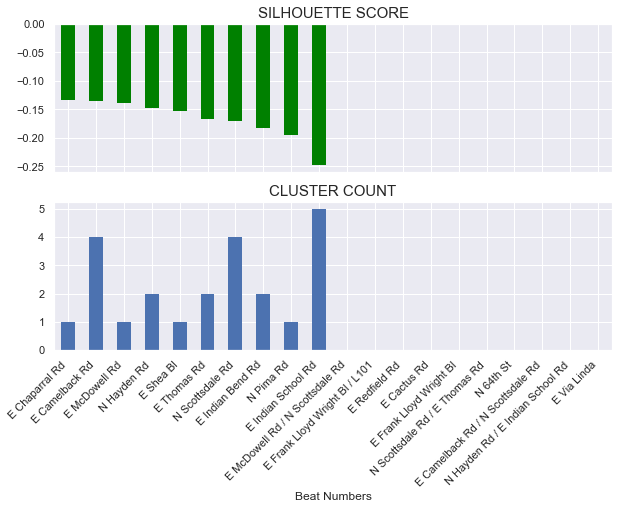

In [42]:
# plot silhouette score and cluster count
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(10, 6))

cluster_scores.loc[:,['sil_score']] \
    .plot(kind='bar', color='green', legend=False, ax=ax0)
ax0.set_title('SILHOUETTE SCORE', fontsize=15)


cluster_scores.loc[:,['cluster_count']] \
    .plot(kind='bar', legend=False, ax=ax1);
ax1.set_title('CLUSTER COUNT', fontsize=15)

plt.xlabel('Beat Numbers')
plt.xticks(rotation=45, horizontalalignment="right");

Beat 6 seems to show the tightest clustering based on silhouette score.

## E Camelback Rd

In [43]:
street = 'E Camelback Rd'

In [44]:
beat_number_df = df[df.street == street]

In [45]:
X = pd.get_dummies(beat_number_df)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [46]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1, 5, 10]:
    for min_samples in [5, 10, 25, 50]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

In [47]:
# tabulate param results from above
# sort by silhouette score & cluster count
pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

,sil_score,cluster_count,eps,min_samples
15,0.344,1,5.0,50
12,0.328,4,5.0,5
13,0.328,4,5.0,10
14,0.328,3,5.0,25
8,0.057,27,1.0,5
10,0.026,1,1.0,25
9,0.009,7,1.0,10
11,-0.155,2,1.0,50
5,-0.229,5,0.5,10
4,-0.274,16,0.5,5


## Model best parameters from above

In [48]:
dbscan_cluster = DBSCAN(eps=5, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts()

0    873
2     34
1     27
3     13
dtype: int64

In [50]:
# format beat 16 data for plotting
beat_number_labels = pd.concat([beat_number_df.reset_index(drop=True).drop('street', axis=1), pd.Series(clusters).rename('cluster')], axis=1)

In [51]:
beat_number_labels

,cited_person_age,charge_description,month,day_of_week,week_of_year,hour_of_day,cluster
0,22.0,Expired/No Arizona Registration,7,1,28,18,0
1,29.0,Speed Greater Than R&P or Posted,3,4,12,22,0
2,29.0,Expired/No Arizona Registration,10,0,43,8,0
3,33.0,DUI-Impaired to Slightest Degree,10,3,44,0,0
4,29.0,DUI-Impaired to Slightest Degree,10,3,44,1,0
...,...,...,...,...,...,...,...
942,45.0,Expired/No Arizona Registration,1,4,2,21,0
943,34.0,Drug Paraphernalia-Possess/Use,9,0,39,12,0
944,18.0,Speed Greater Than R&P or Posted,9,3,39,1,0
945,30.0,Speed Greater Than R&P or Posted,9,5,39,22,0


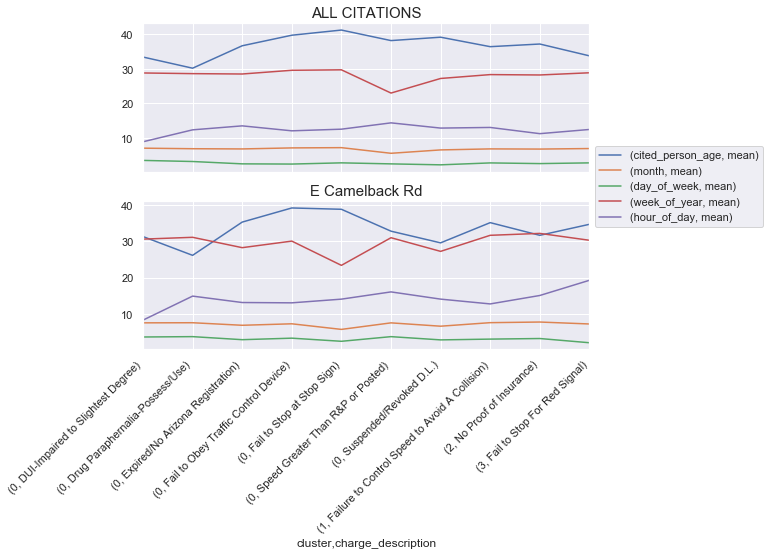

In [54]:
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(8, 6))

df.drop('street', axis=1).groupby(['charge_description']).agg(['mean']).plot(ax=ax0, legend=False)
ax0.set_title('ALL CITATIONS', fontsize=15)

beat_number_labels.groupby(['cluster', 'charge_description']).agg(['mean']).plot(ax=ax1)
ax1.set_title(street, fontsize=15)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 1.1))
plt.xticks(rotation=45, horizontalalignment="right");
# plt.xlabel('CHARGE DESCRIPTION', fontsize=13);

### PCA

In [55]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

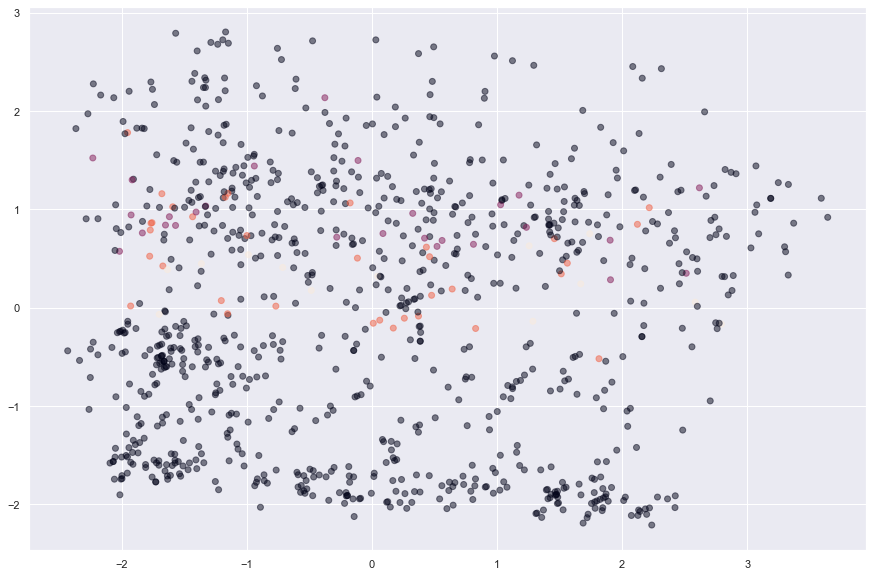

In [56]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5);

### t-SNE

In [57]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 947 samples in 0.001s...
[t-SNE] Computed neighbors for 947 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 947 / 947
[t-SNE] Mean sigma: 1.030898
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.198589
[t-SNE] KL divergence after 300 iterations: 0.425399


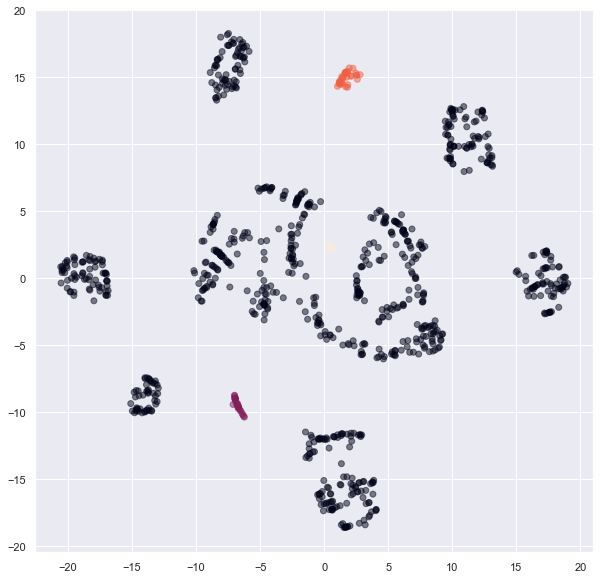

In [58]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters));

### UMAP - iteration 1

In [59]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

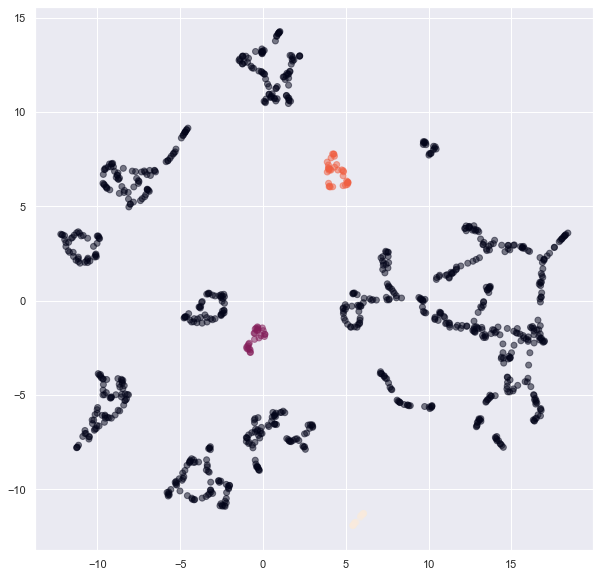

In [60]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters));

## N Scottsdale Rd.

In [61]:
street = 'N Scottsdale Rd'

In [62]:
beat_number_df = df[df.street == street]

In [63]:
X = pd.get_dummies(beat_number_df)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [64]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1, 5, 10]:
    for min_samples in [5, 10, 25, 50]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

In [65]:
# tabulate param results from above
# sort by silhouette score & cluster count
pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

,sil_score,cluster_count,eps,min_samples
19,0.619,1,10.0,50
16,0.569,2,10.0,5
17,0.569,2,10.0,10
18,0.569,2,10.0,25
12,0.339,4,5.0,5
13,0.339,4,5.0,10
14,0.339,4,5.0,25
15,0.337,3,5.0,50
8,0.275,20,1.0,5
9,0.159,15,1.0,10


## Model best parameters from above

In [66]:
dbscan_cluster = DBSCAN(eps=5, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts()

 0    2391
 1     106
 2      64
 3      25
-1       1
dtype: int64

In [67]:
# format beat 16 data for plotting
beat_number_labels = pd.concat([beat_number_df.reset_index(drop=True).drop('street', axis=1), pd.Series(clusters).rename('cluster')], axis=1)

In [68]:
beat_number_labels

,cited_person_age,charge_description,month,day_of_week,week_of_year,hour_of_day,cluster
0,29.0,Failure to Control Speed to Avoid A Collision,7,6,28,14,0
1,21.0,Speed Greater Than R&P or Posted,7,1,28,6,0
2,20.0,Speed Greater Than R&P or Posted,7,3,28,7,0
3,64.0,No Proof of Insurance,7,3,28,9,1
4,35.0,No Proof of Insurance,7,5,28,23,1
...,...,...,...,...,...,...,...
2582,23.0,Speed Greater Than R&P or Posted,9,2,39,7,0
2583,63.0,Speed Greater Than R&P or Posted,9,2,39,7,0
2584,20.0,Speed Greater Than R&P or Posted,9,2,39,8,0
2585,26.0,Speed Greater Than R&P or Posted,9,5,39,8,0


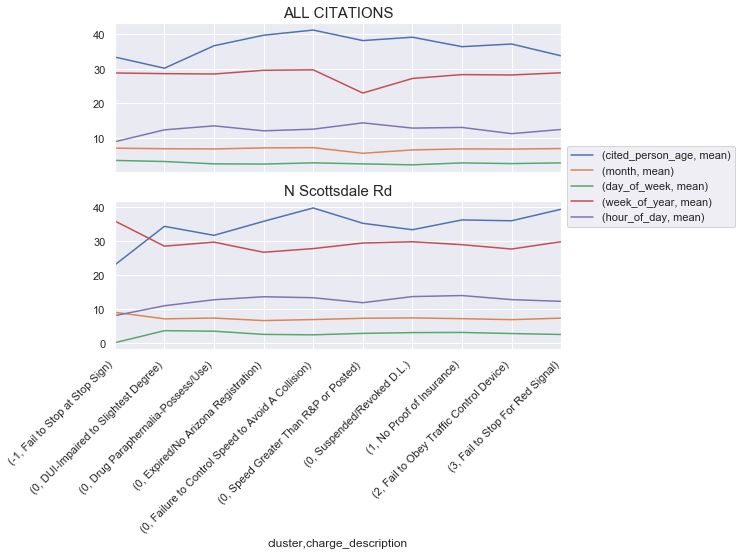

In [69]:
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(8, 6))

df.drop('street', axis=1).groupby(['charge_description']).agg(['mean']).plot(ax=ax0, legend=False)
ax0.set_title('ALL CITATIONS', fontsize=15)

beat_number_labels.groupby(['cluster', 'charge_description']).agg(['mean']).plot(ax=ax1)
ax1.set_title(street, fontsize=15)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 1.1))
plt.xticks(rotation=45, horizontalalignment="right");
# plt.xlabel('CHARGE DESCRIPTION', fontsize=13);

### PCA

In [70]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

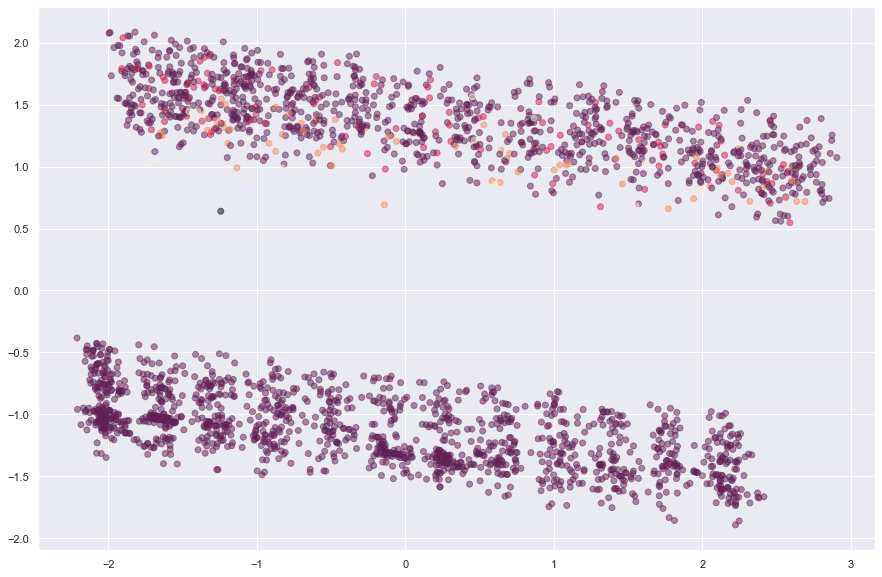

In [71]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5);

### t-SNE

In [72]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2587 samples in 0.008s...
[t-SNE] Computed neighbors for 2587 samples in 0.231s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2587
[t-SNE] Computed conditional probabilities for sample 2000 / 2587
[t-SNE] Computed conditional probabilities for sample 2587 / 2587
[t-SNE] Mean sigma: 0.705915
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.530933
[t-SNE] KL divergence after 300 iterations: 1.103067


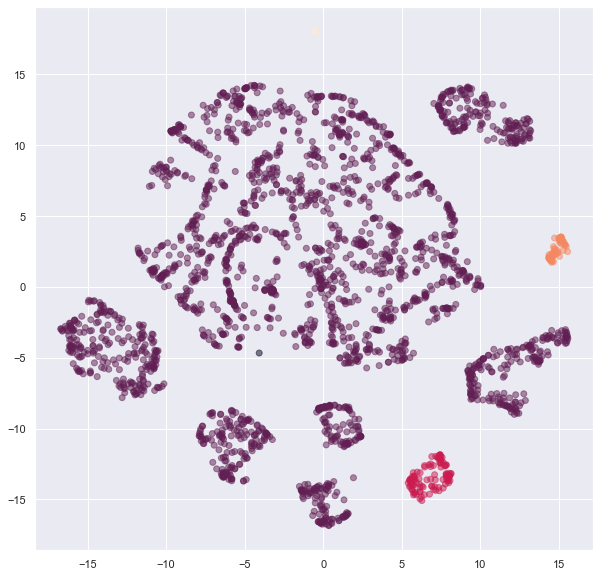

In [73]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters));

### UMAP - iteration 1

In [74]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

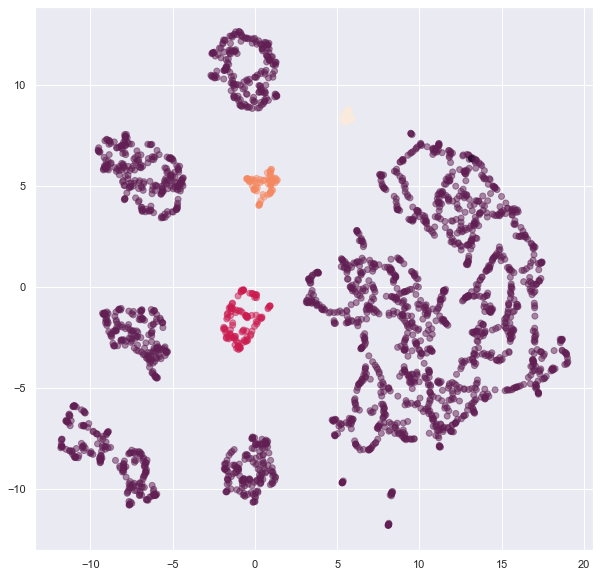

In [75]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters));

## N Indian School Rd

In [80]:
street = 'E Indian School Rd'

In [81]:
beat_number_df = df[df.street == street]

In [82]:
X = pd.get_dummies(beat_number_df)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [83]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1, 5, 10]:
    for min_samples in [5, 10, 25, 50]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

In [84]:
# tabulate param results from above
# sort by silhouette score & cluster count
pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

,sil_score,cluster_count,eps,min_samples
18,0.626,1,10.0,25
19,0.626,1,10.0,50
16,0.569,2,10.0,5
17,0.569,2,10.0,10
12,0.387,6,5.0,5
13,0.387,6,5.0,10
14,0.385,5,5.0,25
15,0.368,4,5.0,50
8,0.152,18,1.0,5
9,0.086,6,1.0,10


## Model best parameters from above

In [85]:
dbscan_cluster = DBSCAN(eps=5, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts()

 1    1104
 2      57
 3      51
 0      50
 4      43
 5      13
-1       1
dtype: int64

In [86]:
# format beat 16 data for plotting
beat_number_labels = pd.concat([beat_number_df.reset_index(drop=True).drop('street', axis=1), pd.Series(clusters).rename('cluster')], axis=1)

In [96]:
beat_number_labels

,cited_person_age,charge_description,month,day_of_week,week_of_year,hour_of_day,cluster
0,48.0,No Proof of Insurance,7,4,28,18,0
1,31.0,No Proof of Insurance,7,4,28,22,0
2,37.0,No Proof of Insurance,7,4,28,8,0
3,33.0,DUI-Impaired to Slightest Degree,7,4,28,23,1
4,40.0,Speed Greater Than R&P or Posted,3,0,12,14,1
...,...,...,...,...,...,...,...
1314,39.0,Expired/No Arizona Registration,9,1,39,12,1
1315,63.0,Failure to Control Speed to Avoid A Collision,10,0,40,5,2
1316,40.0,Speed Greater Than R&P or Posted,9,2,39,14,1
1317,23.0,Speed Greater Than R&P or Posted,9,3,39,12,1


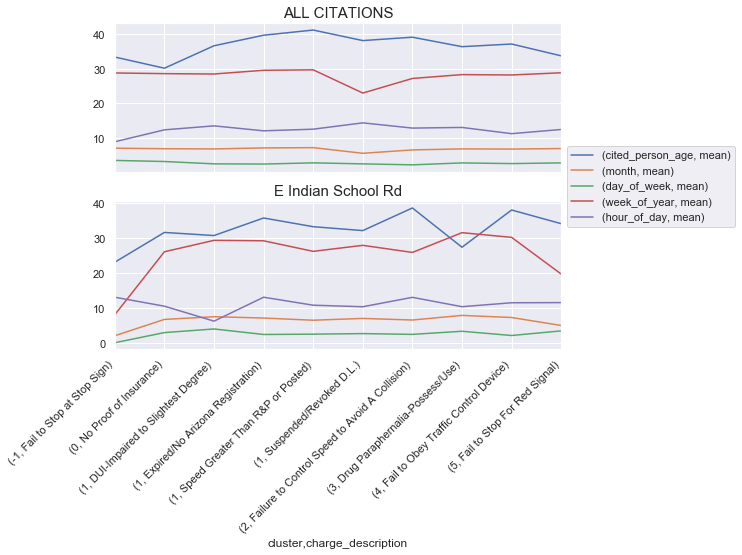

In [88]:
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(8, 6))

df.drop('street', axis=1).groupby(['charge_description']).agg(['mean']).plot(ax=ax0, legend=False)
ax0.set_title('ALL CITATIONS', fontsize=15)

beat_number_labels.groupby(['cluster', 'charge_description']).agg(['mean']).plot(ax=ax1)
ax1.set_title(street, fontsize=15)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 1.1))
plt.xticks(rotation=45, horizontalalignment="right");
# plt.xlabel('CHARGE DESCRIPTION', fontsize=13);

### PCA

In [89]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

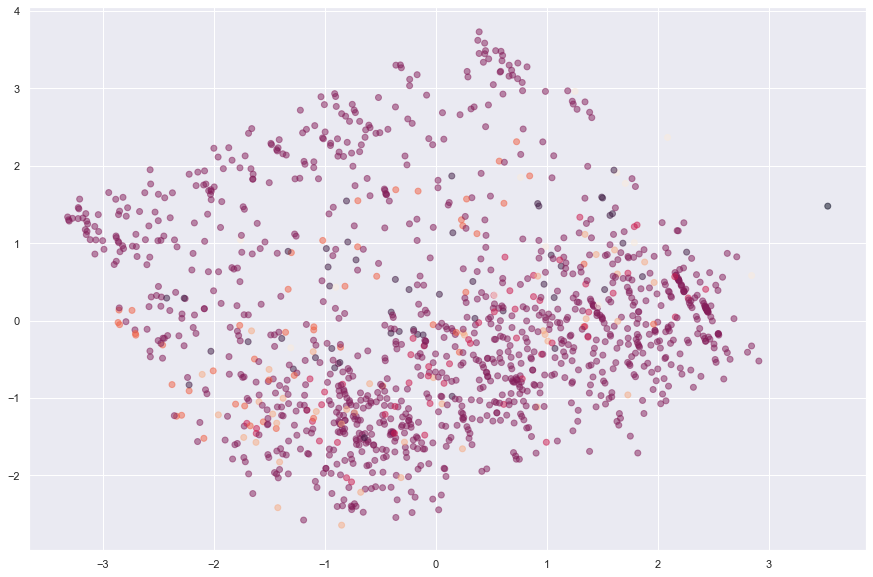

In [90]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5);

### t-SNE

In [91]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1319 samples in 0.003s...
[t-SNE] Computed neighbors for 1319 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1319
[t-SNE] Computed conditional probabilities for sample 1319 / 1319
[t-SNE] Mean sigma: 0.870426
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.254204
[t-SNE] KL divergence after 300 iterations: 0.668720


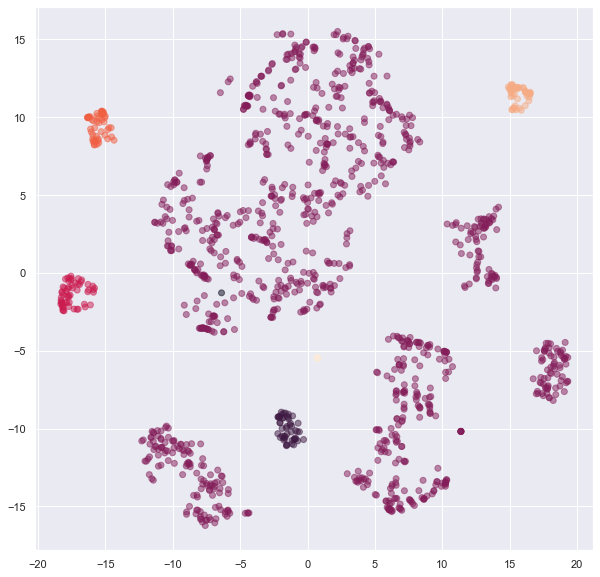

In [92]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters));

### UMAP - iteration 1

In [93]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

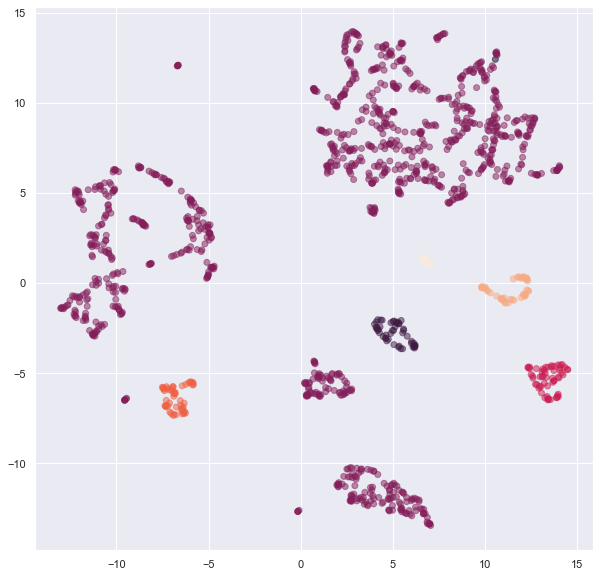

In [94]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters));